<a href="https://colab.research.google.com/github/renataomon/Properties_Price/blob/master/Properties_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a model to predict the property average price of the São Paulo / SP / Brasil, in 2017.
## The data is avaliable from Properaty (Google Big Query)

### Import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler #PADRONIZAÇÃO
from sklearn.linear_model import LogisticRegression #REGRESSÃO LOGÍSTICA
from sklearn.model_selection import train_test_split #SEPARAR OS DADOS
from sklearn.metrics import accuracy_score #ACURÁCIA
#from imblearn.over_sampling import SMOTE #BALANCEAMENTO OVERSAMPLING
from sklearn.metrics import confusion_matrix, classification_report #MATRIZ DE DECISÃO

import warnings
warnings.filterwarnings('ignore') #Ignorar as advertências

In [8]:
%matplotlib inline
np.random.seed(44)

### Import csv file

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
drive_path = '/content/gdrive/My Drive/Colab Notebooks/Git/Properties_Price/Properties_Price/dados/'
#drive_path = 'dados/'
sales = pd.read_csv(drive_path + 'sales.csv')

First records

In [15]:
sales.head()

id  ...                                    image_thumbnail
0  c15906783b301e5bf9a735c91304819b4dd494e9  ...  https://thumbs4.properati.com/1/wDnu4w56VlK5iY...
1  a9ce26735b481b53928c644e26da6d3ab81e6978  ...  https://thumbs4.properati.com/5/tOSNaI9teYLeId...
2  4b186f882e9cd44db6c07c617eda2da4170abccf  ...  https://thumbs4.properati.com/3/E9EzOQtC94lxu3...
3  b83c7841805e6c42f8fc37e9d1b6611a86df9854  ...  https://thumbs4.properati.com/2/KsEVWRLIaEpgfJ...
4  67085da267849879c362a44f38c0fe6d00044c43  ...  https://thumbs4.properati.com/7/A1r_RIm1voNNL5...

[5 rows x 27 columns]

Size of dataset

In [ ]:
sales.shape

(716991, 27)

show dataset columns info

In [ ]:
sales.columns

Index(['id', 'created_on', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat_lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

nomes_colunas = ['id', 'data_criacao', 'operacao', 'tipo_propriedade', 'local',
'local_detalhado', 'pais', 'estado', 'geonames_id',
'lat_lon', 'lat', 'lon', 'preco', 'moeda',
'preco_aprox_moeda_local', 'preco_aprox_usd', 'area_total_m2',
'area_coberta_m2', 'preco_usd_m2', 'preco_m2', 'andar',
'comodos', 'gastos', 'properati_url', 'descricao', 'titulo',
'image_thumbnail']

Verify coluns properties

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716991 entries, 0 to 716990
Data columns (total 27 columns):
id                            716991 non-null object
created_on                    716991 non-null object
operation                     716991 non-null object
property_type                 716991 non-null object
place_name                    716991 non-null object
place_with_parent_names       716991 non-null object
country_name                  716991 non-null object
state_name                    716991 non-null object
geonames_id                   0 non-null float64
lat_lon                       410911 non-null object
lat                           410911 non-null float64
lon                           410911 non-null float64
price                         702021 non-null float64
currency                      700647 non-null object
price_aprox_local_currency    702021 non-null float64
price_aprox_usd               702021 non-null float64
surface_total_in_m2           130967 non

Verify infos about detailed places

In [ ]:
sales['place_with_parent_names'].value_counts()

|Brasil|São Paulo|Santo André|                                33536
|Brasil|São Paulo|Praia Grande|                               31767
|Brasil|São Paulo|Cotia|                                      13743
|Brasil|São Paulo|São Paulo|                                  11604
|Brasil|São Paulo|São Paulo|Moema|                            10210
                                                              ...  
|Brasil|São Paulo|Itatiba|Parque Nova Xampirra|                   1
|Brasil|São Paulo|Bauru|Jardim Planalto|                          1
|Brasil|São Paulo|Campinas|Jardim Nova Morada|                    1
|Brasil|São Paulo|Cabrália Paulista|                              1
|Brasil|São Paulo|Jundiaí|Chácara Recreio Lagoa dos Patos|        1
Name: place_with_parent_names, Length: 4031, dtype: int64

Method "Contains" to filter '|Brasil|São Paulo|São Paulo|'

In [ ]:
sales_sp = sales[sales['place_with_parent_names'].str.contains('|Brasil|São Paulo|São Paulo|', regex=False)]

Verify final results

In [ ]:
sales_sp['place_with_parent_names'].value_counts()

|Brasil|São Paulo|São Paulo|                      11604
|Brasil|São Paulo|São Paulo|Moema|                10210
|Brasil|São Paulo|São Paulo|Campo Belo|            9856
|Brasil|São Paulo|São Paulo|Vila Mariana|          9627
|Brasil|São Paulo|São Paulo|Tatuapé|               8829
                                                  ...  
|Brasil|São Paulo|São Paulo|Jardim Liderança|         1
|Brasil|São Paulo|São Paulo|Jardim Martinica|         1
|Brasil|São Paulo|São Paulo|Parque Industrial|        1
|Brasil|São Paulo|São Paulo|Cidade Luz|               1
|Brasil|São Paulo|São Paulo|Vila Nancy|               1
Name: place_with_parent_names, Length: 637, dtype: int64

Number of records

In [ ]:
print('The dataframe have {} records'.format(sales_sp.shape[0]))

The dataframe have 320397 records


Dataframe have significant records volume yet. Still necessary another filter
Verify possible dates of property ads

In [ ]:
sales_sp['created_on'].unique()

array(['2016-08-19', '2016-08-20', '2017-01-24', '2016-08-30',
       '2016-08-01', '2016-10-21', '2016-08-02', '2017-02-08',
       '2016-08-09', '2016-08-17', '2017-01-14', '2017-01-17',
       '2016-08-24', '2016-08-04', '2016-08-27', '2017-02-04',
       '2016-08-16', '2016-08-28', '2016-08-18', '2016-08-11',
       '2016-08-12', '2016-08-25', '2016-08-13', '2016-08-03',
       '2016-08-07', '2016-08-23', '2017-02-25', '2016-08-22',
       '2016-08-05', '2016-08-26', '2016-10-07', '2016-09-27',
       '2016-08-31', '2016-08-06', '2017-01-07', '2016-08-08',
       '2016-08-10', '2016-08-29', '2016-08-14', '2017-01-28',
       '2016-09-28', '2016-08-15', '2016-10-19', '2017-01-26',
       '2016-08-21', '2016-11-07', '2016-10-09', '2016-10-08',
       '2017-02-22', '2016-12-24', '2016-12-29', '2016-12-21',
       '2016-09-22', '2016-11-24', '2016-10-12', '2016-09-03',
       '2016-11-12', '2016-10-29', '2017-02-01', '2016-09-08',
       '2016-09-18', '2016-12-17', '2016-12-10', '2017-

There are some records of 2016. The job is analysing only 2017.

Chande the values to srt from datetime

In [ ]:
sales_sp['created_on'] = pd.to_datetime(sales['created_on'])

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320397 entries, 726 to 716328
Data columns (total 27 columns):
id                            320397 non-null object
created_on                    320397 non-null datetime64[ns]
operation                     320397 non-null object
property_type                 320397 non-null object
place_name                    320397 non-null object
place_with_parent_names       320397 non-null object
country_name                  320397 non-null object
state_name                    320397 non-null object
geonames_id                   0 non-null float64
lat_lon                       206577 non-null object
lat                           206577 non-null float64
lon                           206577 non-null float64
price                         309159 non-null float64
currency                      308076 non-null object
price_aprox_local_currency    309159 non-null float64
price_aprox_usd               309159 non-null float64
surface_total_in_m2           

filter year for 2017

In [ ]:
sales_sp = sales_sp.query('20170101 <= created_on < 20180101')

Number of records

In [ ]:
print('The dataframe have {} records'.format(sales_sp.shape[0]))

The dataframe have 258093 records


Saving the dataframe    

In [ ]:
sales_sp.to_csv('dados/sales_sp_2017_1.csv', index=False)

## Import the data 'sales_sp_2017_1.csv'

In [ ]:
drive_path = 'dados/'
sales_sp = pd.read_csv(drive_path + 'sales_sp_2017_1.csv')

## What is irrelevant?

'id' - not necessary. Dataframe have index<br>
'operation' - There is only the value 'sell'<br>
'geonames_id' - Only Null values<br>
'lat_lon' - Duplicated values with columns 'lat' and 'lon'<br>
'properati_url' - Not relevant for price prediction<br>
'title' - Not relevant for price prediction<br>
'image_thumbnail' - Not relevant for price prediction<br>
'floor' - few records<br>
'country_name' - There is only the value 'Brasil'<br>
'state_name' - There is only the value 'São Paulo'<br>

In [ ]:
sales_sp.drop(['id', 'operation', 'geonames_id', 'lat_lon', 'properati_url', 'title', 'image_thumbnail',
               'floor', 'country_name', 'state_name'], axis=1, inplace=True)

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258093 entries, 0 to 258092
Data columns (total 17 columns):
created_on                    258093 non-null object
property_type                 258093 non-null object
place_name                    258093 non-null object
place_with_parent_names       258093 non-null object
lat                           169903 non-null float64
lon                           169903 non-null float64
price                         250122 non-null float64
currency                      249475 non-null object
price_aprox_local_currency    250122 non-null float64
price_aprox_usd               250122 non-null float64
surface_total_in_m2           37958 non-null float64
surface_covered_in_m2         232722 non-null float64
price_usd_per_m2              224842 non-null float64
price_per_m2                  224831 non-null float64
rooms                         166279 non-null float64
expenses                      142227 non-null float64
description                   2

Verify null values

In [ ]:
sales_sp.isnull().sum()

created_on                         0
property_type                      0
place_name                         0
place_with_parent_names            0
lat                            88190
lon                            88190
price                           7971
currency                        8618
price_aprox_local_currency      7971
price_aprox_usd                 7971
surface_total_in_m2           220135
surface_covered_in_m2          25371
price_usd_per_m2               33251
price_per_m2                   33262
rooms                          91814
expenses                      115866
description                        0
dtype: int64

Delete null values from 'lat', 'lon'

In [ ]:
sales_sp.dropna(subset=['lat', 'lon'], inplace=True)

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169903 entries, 185 to 258092
Data columns (total 17 columns):
created_on                    169903 non-null object
property_type                 169903 non-null object
place_name                    169903 non-null object
place_with_parent_names       169903 non-null object
lat                           169903 non-null float64
lon                           169903 non-null float64
price                         167230 non-null float64
currency                      166991 non-null object
price_aprox_local_currency    167230 non-null float64
price_aprox_usd               167230 non-null float64
surface_total_in_m2           27316 non-null float64
surface_covered_in_m2         159580 non-null float64
price_usd_per_m2              156501 non-null float64
price_per_m2                  156490 non-null float64
rooms                         109228 non-null float64
expenses                      93662 non-null float64
description                   

In [ ]:
sales_sp['currency'].value_counts()

BRL    166991
Name: currency, dtype: int64

Verify the price values

In [ ]:
sales_sp[['price', 'price_aprox_local_currency', 'price_aprox_usd', 'price_usd_per_m2']].head(10)

price  price_aprox_local_currency  price_aprox_usd  price_usd_per_m2
185   470000.0                   493336.53        150655.51       1255.462583
186   550000.0                   579500.62        176968.37       1882.642234
187  2285000.0                  2410897.33        736241.78               NaN
188   530000.0                   564861.81        172497.96       2395.805000
189   420000.0                   444846.51        135847.59       3396.189750
190        0.0                        0.00             0.00               NaN
191  1600000.0                  1675737.22        511737.99       3708.246304
192   378000.0                   394203.42        120382.16       1744.668986
193   460000.0                   490257.42        149715.21       2722.094727
194   700000.0                   746043.93        227827.50       2958.798701

We are using only the columns 'price'. It seems to be more accurate and rounded<br>
Delete the columns 'price_aprox_local_currency', 'price_aprox_usd', 'price_usd_per_m2'

In [ ]:
sales_sp.drop(['price_aprox_local_currency', 'price_aprox_usd', 'price_usd_per_m2'], axis=1, inplace=True)

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169903 entries, 185 to 258092
Data columns (total 14 columns):
created_on                 169903 non-null object
property_type              169903 non-null object
place_name                 169903 non-null object
place_with_parent_names    169903 non-null object
lat                        169903 non-null float64
lon                        169903 non-null float64
price                      167230 non-null float64
currency                   166991 non-null object
surface_total_in_m2        27316 non-null float64
surface_covered_in_m2      159580 non-null float64
price_per_m2               156490 non-null float64
rooms                      109228 non-null float64
expenses                   93662 non-null float64
description                169903 non-null object
dtypes: float64(8), object(6)
memory usage: 19.4+ MB


Let's check the surfaces columns

In [ ]:
sales_sp[['surface_total_in_m2', 'surface_covered_in_m2', 'price_per_m2']].head(10)

surface_total_in_m2  surface_covered_in_m2  price_per_m2
185                 87.0                  120.0   3916.666667
186                  NaN                   94.0   5851.063830
187                225.0                    NaN           NaN
188                  NaN                   72.0   7361.111111
189                  NaN                   40.0  10500.000000
190                  NaN                   46.0           NaN
191                224.0                  138.0  11594.202899
192                  NaN                   69.0   5478.260870
193                 95.0                   55.0   8363.636364
194                  NaN                   77.0   9090.909091

Columns 'surface_total_in_m2' there are few values compared with 'surface_covered_in_m2'.<br>
Will be consider only the 'surface_covered_in_m2', because there are more records and more relevant also.

In [ ]:
sales_sp.drop(['surface_total_in_m2'], axis=1, inplace=True)

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169903 entries, 185 to 258092
Data columns (total 13 columns):
created_on                 169903 non-null object
property_type              169903 non-null object
place_name                 169903 non-null object
place_with_parent_names    169903 non-null object
lat                        169903 non-null float64
lon                        169903 non-null float64
price                      167230 non-null float64
currency                   166991 non-null object
surface_covered_in_m2      159580 non-null float64
price_per_m2               156490 non-null float64
rooms                      109228 non-null float64
expenses                   93662 non-null float64
description                169903 non-null object
dtypes: float64(7), object(6)
memory usage: 18.1+ MB


Verify is there are missing data

In [ ]:
sales_sp.isna().sum()

created_on                     0
property_type                  0
place_name                     0
place_with_parent_names        0
lat                            0
lon                            0
price                       2673
currency                    2912
surface_covered_in_m2      10323
price_per_m2               13413
rooms                      60675
expenses                   76241
description                    0
dtype: int64

Verify in the column 'surface_covered_in_m2' there are "0' values

In [ ]:
sales_sp[sales_sp['surface_covered_in_m2'] == 0.0].count()

created_on                 305
property_type              305
place_name                 305
place_with_parent_names    305
lat                        305
lon                        305
price                      304
currency                   304
surface_covered_in_m2      305
price_per_m2                 0
rooms                        0
expenses                     0
description                305
dtype: int64

Delete the "0" values

In [ ]:
sales_sp = sales_sp[sales_sp['surface_covered_in_m2'] > 0.0]

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159275 entries, 185 to 258092
Data columns (total 13 columns):
created_on                 159275 non-null object
property_type              159275 non-null object
place_name                 159275 non-null object
place_with_parent_names    159275 non-null object
lat                        159275 non-null float64
lon                        159275 non-null float64
price                      156713 non-null float64
currency                   156490 non-null object
surface_covered_in_m2      159275 non-null float64
price_per_m2               156490 non-null float64
rooms                      104977 non-null float64
expenses                   93518 non-null float64
description                159275 non-null object
dtypes: float64(7), object(6)
memory usage: 17.0+ MB


Verify again if there are missing data

In [ ]:
sales_sp.isna().sum()

created_on                     0
property_type                  0
place_name                     0
place_with_parent_names        0
lat                            0
lon                            0
price                       2562
currency                    2785
surface_covered_in_m2          0
price_per_m2                2785
rooms                      54298
expenses                   65757
description                    0
dtype: int64

Delete the null values from 'price_per_m2'

In [ ]:
sales_sp.dropna(subset=['price_per_m2'], inplace=True)

 There are missing data?

In [ ]:
sales_sp.isna().sum()

created_on                     0
property_type                  0
place_name                     0
place_with_parent_names        0
lat                            0
lon                            0
price                          0
currency                       0
surface_covered_in_m2          0
price_per_m2                   0
rooms                      52587
expenses                   64571
description                    0
dtype: int64

Delete null values from 'rooms', 'expenses'

In [ ]:
sales_sp.dropna(subset=['rooms', 'expenses'], inplace=True)

Last verificaton of missing data.....

In [ ]:
sales_sp.isna().sum()

created_on                 0
property_type              0
place_name                 0
place_with_parent_names    0
lat                        0
lon                        0
price                      0
currency                   0
surface_covered_in_m2      0
price_per_m2               0
rooms                      0
expenses                   0
description                0
dtype: int64

In [ ]:
sales_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62389 entries, 188 to 258088
Data columns (total 13 columns):
created_on                 62389 non-null object
property_type              62389 non-null object
place_name                 62389 non-null object
place_with_parent_names    62389 non-null object
lat                        62389 non-null float64
lon                        62389 non-null float64
price                      62389 non-null float64
currency                   62389 non-null object
surface_covered_in_m2      62389 non-null float64
price_per_m2               62389 non-null float64
rooms                      62389 non-null float64
expenses                   62389 non-null float64
description                62389 non-null object
dtypes: float64(7), object(6)
memory usage: 6.7+ MB


Saving the dataframe

In [ ]:
sales_sp.to_csv('dados/sales_sp_2017_2.csv', index=False)

## Import the data 'sales_sp_2017_2.csv'

In [ ]:
drive_path = 'dados/'
sales_sp = pd.read_csv(drive_path + 'sales_sp_2017_2.csv')

### - Transforming data
### - Property description data collection

In [ ]:
sales_sp['description'].values

array(['Apartamento todo reformado em ótimo estado .  Próximo ao metrô e ao shop. Tatuapé  Consulte um de nossos corretores',
       '.Apartamento JARDIM PAULISTA  com:  40.00 m² de área útil, 1 dormitório, sala de jantar, sala de estar, área de serviço, armário embutido, armário de cozinha. Condomínio com: portão eletrônico, recuo, condomínio fechado, jardim, play ground, salão de festas, 1 vaga de garagem.  Valor IPTU: R$80,00 e  Valor Condomínio: R$827,00. CRECI 7.702-J / CRECI 11.031-J',
       'Excelente apartamento no melhor  do Jaguaré , tendo 3 dormitórios, sendo 1 suíte, sala ampla para 2 ambientes, com varanda, cozinha planejada, área de serviço, garagem para 2 automóveis, área de lazer maravilhosa, um perfeito Club, dentro do condomínio. Venha  conferir e marque já a sua visita, estamos aguardando',
       ...,
       '   Editor HTML Online       Conj. Hab. Joseacute; Bonifaacute;cio  -   Oportunidade de Negoacute;cio   - Excelente Apartamento Meacute;dio, com oacute;tima di

Verify the word 'piscina'(pool) in 'description'

In [ ]:
sales_sp['description'].str.contains('piscina', regex=False, case=False).sum()

20217

### Create another column 'poll' with values 1 and 0

Create a list with 'piscina' values

In [ ]:
pool = []

for description in sales_sp['description'].values:
    if 'piscina'.lower() in description.lower():
        pool.append(1)
    else:
        pool.append(0)

Verify if the amount is the same

In [ ]:
len(pool) == sales_sp.shape[0]

True

Create a new column 'pool' in dataframe

In [ ]:
sales_sp['pool'] = pool

### Create columns 'garage', 'metro' with values 1 and 0 from 'description'

Verify amount of 'vaga', 'garagem', 'metro'

In [ ]:
sales_sp['description'].str.contains('vaga', regex=False, case=False).sum()

37239

In [ ]:
sales_sp['description'].str.contains('garagem', regex=False, case=False).sum()

21599

In [ ]:
sales_sp['description'].str.contains('metrô', regex=False, case=False).sum()

13119

In [ ]:
garage = []

for description in sales_sp['description']:
    if 'vaga'.lower() in description.lower() or 'garagem'.lower() in description.lower():
        garage.append(1)
    else:
        garage.append(0)

In [ ]:
metro = []

for description in sales_sp['description']:
    if 'metrô'.lower() in description.lower():
        metro.append(1)
    else:
        metro.append(0)

Verify if the amount is the same

In [ ]:
len(garage) == sales_sp.shape[0]

True

In [ ]:
len(metro) == sales_sp.shape[0]

True

Create a new columns 'garage' and 'metro'(subway) in dataframe

In [ ]:
sales_sp['garage'] = garage
sales_sp['metro'] = metro

In [ ]:
sales_sp.head()

created_on property_type          place_name  \
0  2017-01-13     apartment             Tatuapé   
1  2017-01-11     apartment     Jardim Paulista   
2  2017-01-29     apartment        Vila Lageado   
3  2017-02-18     apartment  Vila Regente Feijó   
4  2017-02-15     apartment     Jardim Paulista   

                           place_with_parent_names        lat        lon  \
0             |Brasil|São Paulo|São Paulo|Tatuapé| -23.536985 -46.573380   
1     |Brasil|São Paulo|São Paulo|Jardim Paulista| -23.571201 -46.652710   
2        |Brasil|São Paulo|São Paulo|Vila Lageado| -23.553284 -46.748257   
3  |Brasil|São Paulo|São Paulo|Vila Regente Feijó| -23.559198 -46.570202   
4     |Brasil|São Paulo|São Paulo|Jardim Paulista| -23.566362 -46.662746   

       price currency  surface_covered_in_m2  price_per_m2  rooms  expenses  \
0   530000.0      BRL                   72.0   7361.111111    2.0     560.0   
1   420000.0      BRL                   40.0  10500.000000    1.0     827.0   
2   550000.0      BRL                   70.0   7857.142857    1.0     445.0   
3   700000.0      BRL                   82.0   8536.585366    1.0     600.0   
4  1150000.0      BRL                  112.0  10267.857143    2.0    1200.0   

                                         description  pool  garage  metro  
0  Apartamento todo reformado em ótimo estado .  ...     0       0      1  
1  .Apartamento JARDIM PAULISTA  com:  40.00 m² d...     0       1      0  
2  Excelente apartamento no melhor  do Jaguaré , ...     0       1      0  
3  LINDO APTO (LOCAÇÃO)  Apartamento Novo com 88M...     1       1      0  
4  O apartamento tem 112 metros quadrados, na par...     0       0      0

Verify the room column

In [ ]:
sales_sp['rooms'].value_counts()

1.0     38779
2.0     17743
3.0      4670
4.0       915
5.0       174
6.0        33
8.0        19
7.0        15
10.0        9
12.0        7
16.0        4
15.0        4
14.0        4
11.0        4
9.0         3
21.0        2
17.0        2
18.0        1
24.0        1
Name: rooms, dtype: int64

Is not common a apartment or house there are just 1 or 2 rooms.<br>
Let's extract the rooms number of description:

In [ ]:
import re

numbers_dict = {'um': 1, 'dois': 2, 'tres': 3, 'três': 3, 'quatro': 4, 'cinco': 5,
                'seis': 6, 'sete': 7, 'oito': 8, 'nove': 9, 'dez': 10}

In [ ]:
num_rooms = []

for description in sales_sp.description.values:
    result = re.search("([0-9]|(um|dois|tres|três|quatro|cinco|seis|sete|oito|nove)"
                         ").(quarto|dorm)", description, flags=re.IGNORECASE)
    if result:
        text_number = result.group().split()[0]
        if text_number.isnumeric():
            number = int(text_number)
            num_rooms.append(number)
        else:
            if text_number.lower() in numbers_dict.keys():
                number = numbers_dict[text_number.lower()]
                num_rooms.append(int(number))
            else:
                num_rooms.append(0)
    else:
        num_rooms.append(0)

In [ ]:
num_rooms[:20]

[0, 1, 3, 3, 2, 2, 3, 3, 1, 2, 3, 3, 1, 0, 2, 0, 0, 2, 0, 0]

Is not the best soluctions, but the data are quite acceptable<br>
Create a new column 'num_rooms' in dataframe

In [ ]:
sales_sp['num_rooms'] = num_rooms

In [ ]:
sales_sp.head()

created_on property_type          place_name  \
0  2017-01-13     apartment             Tatuapé   
1  2017-01-11     apartment     Jardim Paulista   
2  2017-01-29     apartment        Vila Lageado   
3  2017-02-18     apartment  Vila Regente Feijó   
4  2017-02-15     apartment     Jardim Paulista   

                           place_with_parent_names        lat        lon  \
0             |Brasil|São Paulo|São Paulo|Tatuapé| -23.536985 -46.573380   
1     |Brasil|São Paulo|São Paulo|Jardim Paulista| -23.571201 -46.652710   
2        |Brasil|São Paulo|São Paulo|Vila Lageado| -23.553284 -46.748257   
3  |Brasil|São Paulo|São Paulo|Vila Regente Feijó| -23.559198 -46.570202   
4     |Brasil|São Paulo|São Paulo|Jardim Paulista| -23.566362 -46.662746   

       price currency  surface_covered_in_m2  price_per_m2  rooms  expenses  \
0   530000.0      BRL                   72.0   7361.111111    2.0     560.0   
1   420000.0      BRL                   40.0  10500.000000    1.0     827.0   
2   550000.0      BRL                   70.0   7857.142857    1.0     445.0   
3   700000.0      BRL                   82.0   8536.585366    1.0     600.0   
4  1150000.0      BRL                  112.0  10267.857143    2.0    1200.0   

                                         description  pool  garage  metro  \
0  Apartamento todo reformado em ótimo estado .  ...     0       0      1   
1  .Apartamento JARDIM PAULISTA  com:  40.00 m² d...     0       1      0   
2  Excelente apartamento no melhor  do Jaguaré , ...     0       1      0   
3  LINDO APTO (LOCAÇÃO)  Apartamento Novo com 88M...     1       1      0   
4  O apartamento tem 112 metros quadrados, na par...     0       0      0   

   num_rooms  
0          0  
1          1  
2          3  
3          3  
4          2

In [ ]:
sales_sp.to_csv('dados/sales_sp_2017_3.csv', index=False)

 ## Exploratory Data Analysis

In [ ]:
drive_path = 'dados/'
sales_sp = pd.read_csv(drive_path + 'sales_sp_2017_3.csv')

In [ ]:
import pandas_profiling

In [ ]:
pandas_profiling.ProfileReport(sales_sp)

#### Central Tendency

In [ ]:
sales_sp['price'].mean()

937495.7962301046

In [ ]:
sales_sp['price'].median()

630000.0

In [ ]:
sales_sp['price'].mode()

0    450000.0
dtype: float64

#### Data Dispersion

Price Coef. Variation

In [ ]:
cv_price = (sales_sp['price'].std()/sales_sp['price'].mean())
print(cv_price)

1.2693136190929444


In [ ]:
cv_surface = (sales_sp['surface_covered_in_m2'].std()/sales_sp['surface_covered_in_m2'].mean())
print(cv_surface)

14.72351549929657


We can conclude property data are more scattered about surface_covered_in_m2 than price

In [ ]:
sales_sp.describe().round(2)

lat       lon        price  surface_covered_in_m2  price_per_m2  \
count  62389.00  62389.00     62389.00               62389.00      62389.00   
mean     -23.58    -46.65    937495.80                 117.02       8102.22   
std        0.06      0.07   1189976.18                1722.88       8118.08   
min      -23.88    -51.93     68000.00                   1.00          1.84   
25%      -23.61    -46.69    410000.00                  61.00       5925.93   
50%      -23.58    -46.65    630000.00                  81.00       7545.45   
75%      -23.55    -46.61   1050000.00                 127.00       9478.53   
max      -14.24    -45.55  45000000.00              429030.00    1600000.00   

          rooms    expenses      pool    garage     metro  num_rooms  
count  62389.00    62389.00  62389.00  62389.00  62389.00   62389.00  
mean       1.50     1760.22      0.32      0.62      0.21       1.48  
std        0.81    34472.80      0.47      0.49      0.41       1.39  
min        1.00        1.00      0.00      0.00      0.00       0.00  
25%        1.00      480.00      0.00      0.00      0.00       0.00  
50%        1.00      700.00      0.00      1.00      0.00       2.00  
75%        2.00     1130.00      1.00      1.00      0.00       3.00  
max       24.00  5100000.00      1.00      1.00      1.00       7.00

In [ ]:
sales_sp['price'].describe().round(2)

count       62389.00
mean       937495.80
std       1189976.18
min         68000.00
25%        410000.00
50%        630000.00
75%       1050000.00
max      45000000.00
Name: price, dtype: float64

## Data Vizualization

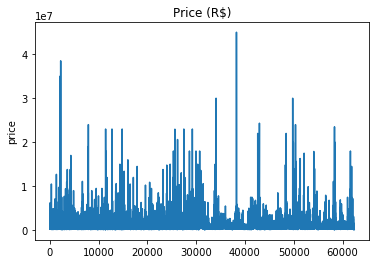

In [ ]:
plt.plot(sales_sp['price']);
plt.title('Price (R$)');
plt.ylabel('price');

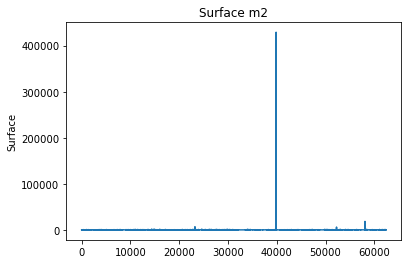

In [ ]:
plt.plot(sales_sp['surface_covered_in_m2']);
plt.title('Surface m2');
plt.ylabel('Surface');

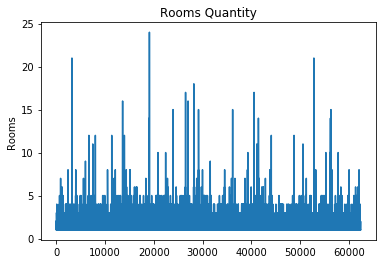

In [ ]:
plt.plot(sales_sp['rooms']);
plt.title('Rooms Quantity');
plt.ylabel('Rooms');

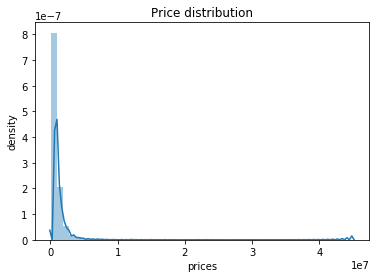

In [ ]:
sns.distplot(sales_sp['price']);
plt.title('Price distribution');
plt.xlabel('prices');
plt.ylabel('density');

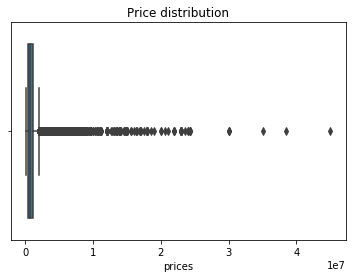

In [ ]:
sns.boxplot(sales_sp['price']);
plt.title('Price distribution');
plt.xlabel('prices');

In [ ]:
sales_sp['price_log'] = np.log(sales_sp['price'])
sales_sp['surface_log'] = np.log(sales_sp.surface_covered_in_m2)

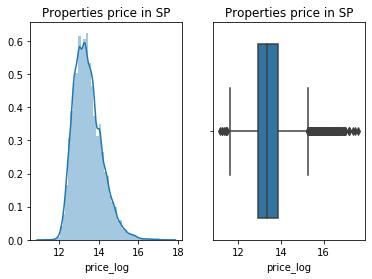

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.distplot(sales_sp['price_log'], ax=ax[0]);
ax[0].set_title('Properties price in SP');
sns.boxplot(sales_sp['price_log'], ax=ax[1]);
ax[1].set_title('Properties price in SP');

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.distplot(sales_sp['surface_log'], ax=ax[0]);
ax[0].set_title('Properties price in SP');
sns.boxplot(sales_sp['surface_log'], ax=ax[1]);
ax[1].set_title('Properties price in SP');